# Linear probing of DINOv2 for semantic segmentation

In this notebook, we're going to train a linear classifier on top of a frozen [DINOv2](https://huggingface.co/docs/transformers/main/model_doc/dinov2) backbone for semantic segmentation (the task of predicting a semantic category for every pixel in an image). DINOv2 is a vision transformer trained in a self-supervised fashion on a highly curated dataset of 142 million images. At the time of writing, it provides one of the best **image features** (i.e. embeddings) which one can use for downstream tasks such as image classification, image segmentation and depth estimation. This makes DINOv2 one of the best **backbones** (i.e. the first building block you typically use in your pipeline) for computer vision tasks nowadays.

In their paper, the authors show that a decoder head as simple as a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) on top of it already beats existing state-of-the-art methods. Of course, using heavier, more complex decoder heads leads to even better performance. For instance, if you add a [Mask2Former](https://huggingface.co/docs/transformers/main/model_doc/mask2former) decoder head on top of DINOv2 as backbone for semantic segmentation, you get even better performance.

The figure below illustrates the idea; we're just going to train a linear transformation on top of a frozen DINOv2 backbone, which will convert the features (patch embeddings) to the logits (the unnormalized scores which neural networks output, indicating the model's predictions). In case of semantic segmentation, the logits will be of shape (batch_size, num_classes, height, width), as one predicts a class per pixel.

<img src="https://huggingface.co/datasets/nielsr/sample-images/resolve/main/dinov2_linear_classifier_bis.png"
alt="drawing" width="300"/>

* DINOv2 docs: https://huggingface.co/docs/transformers/main/model_doc/dinov2.

* DINOv2 blog post: https://dinov2.metademolab.com/.

Special thank you to the people in [this Github thread](https://github.com/facebookresearch/dinov2/issues/25) which inspired me to create this tutorial.


## Set-up environment

Let's start by installing our favorite libraries: 🤗 Transformers and 🤗 Datasets. We install Transformers from source since the model is brand new at the time of writing.

In [57]:
BATCH_SIZE = 8

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

We'll also use 🤗 Evaluate to calculate metrics.

In [3]:
!pip install -q evaluate

## Load dataset

Next, let's load an image segmentation dataset. In this case, we'll use the [FoodSeg](https://huggingface.co/datasets/EduardoPacheco/FoodSeg103) dataset.

Want to use your own custom dataset? [Here](https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation#note-on-custom-data)'s a guide regarding turning it into a 🤗 dataset (and you could potentially upload it to the hub as a public/private repo).

Let's take a look at the dataset in more detail. It has a train and validation split:

Let's take a look at the first training example:

In [58]:
import os 
from tqdm import tqdm
import numpy as np
from PIL import Image as pilImage
from datasets import Dataset as d
from datasets import Dataset, DatasetDict, Features, Image, Sequence, Value

dataset_path_img = "C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/images/train"
dataset_path_lbl = "C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/labels/train"
# Get the list of image files and label files
image_files = [os.path.join(dataset_path_img, f) for f in os.listdir(dataset_path_img) if f.endswith(('.png', '.jpg', '.jpeg'))]
label_files = [os.path.join(dataset_path_lbl, f) for f in os.listdir(dataset_path_lbl) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_to_label = {os.path.basename(img): lbl for img, lbl in zip(image_files, label_files)}

#split image flies to train and val randomly
np.random.seed(0)
np.random.shuffle(image_files)
image_files_train = image_files[:int(len(image_files)*0.8)]
image_files_val = image_files[int(len(image_files)*0.8):]


print("example of the first path of an image file after shuffling: ", image_files[0])
print("example of label file: ", label_files[0])

# Define the classes
classes = ["soil", "bedrock", "sand", "bigRock", "noLabel"]

# Create a dataset from the image files
features = Features({
    'image': Image(),
    'label': Image(),
    #'classes_on_image': Sequence(Value('int32')),
    #'id': Value('int32')
})


print(f"example correspondence {image_files[0]} example correspondence, {image_to_label[os.path.basename(image_files[0])]}")


# Custom function to extract unique values from the label image
def extract_classes_on_image(label_path):
    label_image = np.array(pilImage.open(label_path))
    return np.unique(label_image).tolist()

# Example data creation
data_train = []
data_val = []
for idx, img_path in enumerate(tqdm(image_files, desc="Processing images")):
    img_basename = os.path.basename(img_path)
    label_path = image_to_label[img_basename]
    
    
    #classes_on_image = extract_classes_on_image(label_path)
    if(img_path in image_files_train):
        data_train.append({
            'image': img_path,
            'label': label_path,
            #'classes_on_image': classes_on_image,
            #'id': idx
        })
    else:
        data_val.append({
            'image': img_path,
            'label': label_path,
            #'classes_on_image': classes_on_image,
            #'id': idx
        })

# Create the dataset
dataset_S5Mars = DatasetDict({
    'train': d.from_list(data_train, features=features),
    'validation': d.from_list(data_val, features=features)
})

# Print the dataset
print(dataset_S5Mars)

example of the first path of an image file after shuffling:  C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/images/train\NLB_558082318EDR_F0653200NCAM00207M1.png
example of label file:  C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/labels/train\NLA_397586934EDR_F0010008AUT_04096M1.png
example correspondence C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/images/train\NLB_558082318EDR_F0653200NCAM00207M1.png example correspondence, C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/labels/train\NLB_558082318EDR_F0653200NCAM00207M1.png


Processing images: 100%|██████████| 16064/16064 [00:01<00:00, 11283.69it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12851
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3213
    })
})


In [6]:
import numpy as np
from PIL import Image
from tqdm import tqdm
'''
IMG_SIZE = 448

# Define a function to resize images and masks
def resize_images_and_masks(example):
    example['image'] = example['image'].resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    example['label'] = example['label'].resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
    return example

# Generator to yield resized images
def resized_image_generator(dataset):
    for example in dataset:
        resized_example = resize_images_and_masks(example)
        yield np.array(resized_example['image'])

# Initialize variables to calculate mean and std
sum_images = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float64)
sum_squared_images = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float64)
num_images = 0

# Process images on-the-fly
for img in tqdm(resized_image_generator(dataset_S5Mars['train']), desc="Processing images"):
    sum_images += img
    sum_squared_images += img ** 2
    num_images += 1

# Calculate mean and std for each channel
means = (sum_images / num_images) / 255.0
stds = (np.sqrt(sum_squared_images / num_images - (sum_images / num_images) ** 2)) / 255.0

print("Means:", means)
print("Stds:", stds)'''

'\nIMG_SIZE = 448\n\n# Define a function to resize images and masks\ndef resize_images_and_masks(example):\n    example[\'image\'] = example[\'image\'].resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)\n    example[\'label\'] = example[\'label\'].resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)\n    return example\n\n# Generator to yield resized images\ndef resized_image_generator(dataset):\n    for example in dataset:\n        resized_example = resize_images_and_masks(example)\n        yield np.array(resized_example[\'image\'])\n\n# Initialize variables to calculate mean and std\nsum_images = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float64)\nsum_squared_images = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float64)\nnum_images = 0\n\n# Process images on-the-fly\nfor img in tqdm(resized_image_generator(dataset_S5Mars[\'train\']), desc="Processing images"):\n    sum_images += img\n    sum_squared_images += img ** 2\n    num_images += 1\n\n# Calculate mean and std for each channel\nmeans = (sum_i

In [6]:
'''sum_images = sum_images.sum(axis=(0, 1))
sum_squared_images = sum_squared_images.sum(axis=(0, 1))

sum_images = ((sum_images/ IMG_SIZE) /IMG_SIZE) /255
sum_squared_images = ((sum_squared_images/IMG_SIZE) /IMG_SIZE) /255

means = (sum_images / num_images)
print("Means:", means)


stds = (np.sqrt(sum_squared_images / num_images - (sum_images / num_images) ** 2))
print("Std:", stds)

'''

'sum_images = sum_images.sum(axis=(0, 1))\nsum_squared_images = sum_squared_images.sum(axis=(0, 1))\n\nsum_images = ((sum_images/ IMG_SIZE) /IMG_SIZE) /255\nsum_squared_images = ((sum_squared_images/IMG_SIZE) /IMG_SIZE) /255\n\nmeans = (sum_images / num_images)\nprint("Means:", means)\n\n\nstds = (np.sqrt(sum_squared_images / num_images - (sum_images / num_images) ** 2))\nprint("Std:", stds)\n\n'

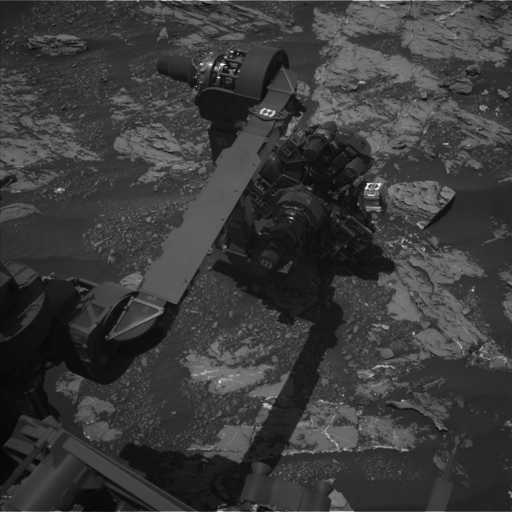

In [59]:
example = dataset_S5Mars["train"][0]
image = example["image"]
image

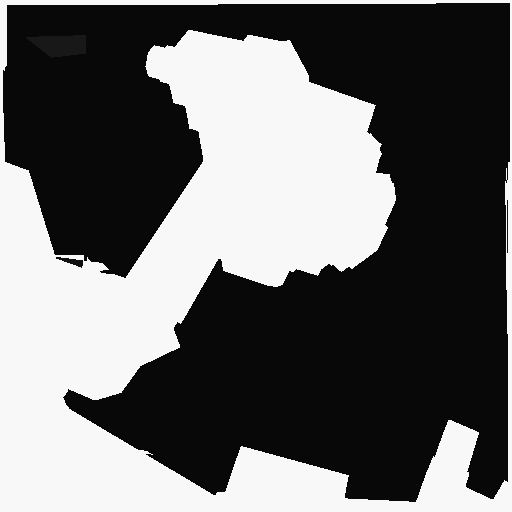

In [60]:
segmentation_map = example["label"]
# plot the segmentation map increasing the value *2
segmentation_map = np.array(segmentation_map)
segmentation_map2 = segmentation_map * 8
segmentation_map2 = pilImage.fromarray(segmentation_map2)
segmentation_map2

In case of semantic segmentation, every pixel is labeled with a certain class. 0 is the "background" class.

In [9]:
import numpy as np

segmentation_map = np.array(segmentation_map)
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Let's load the mappings between integers and their classes (I got that from the [dataset card](https://huggingface.co/datasets/EduardoPacheco/FoodSeg103#data-categories) and asked an LLM to turn it into a dictionary).

In [61]:
classes2names = {
        0:   "soil", 
        1:   "bedrock", 
        2:   "sand", 
        3:   "bigRock", 
        255: "noLabel"
    }



In [11]:
print(classes2names)

{0: 'null', 1: 'sky', 2: 'ridge', 3: 'soil', 4: 'sand', 5: 'bedrock', 6: 'rock', 7: 'rover', 8: 'trace', 9: 'hole'}


We can visualize the segmentation map on top of the image, like so:

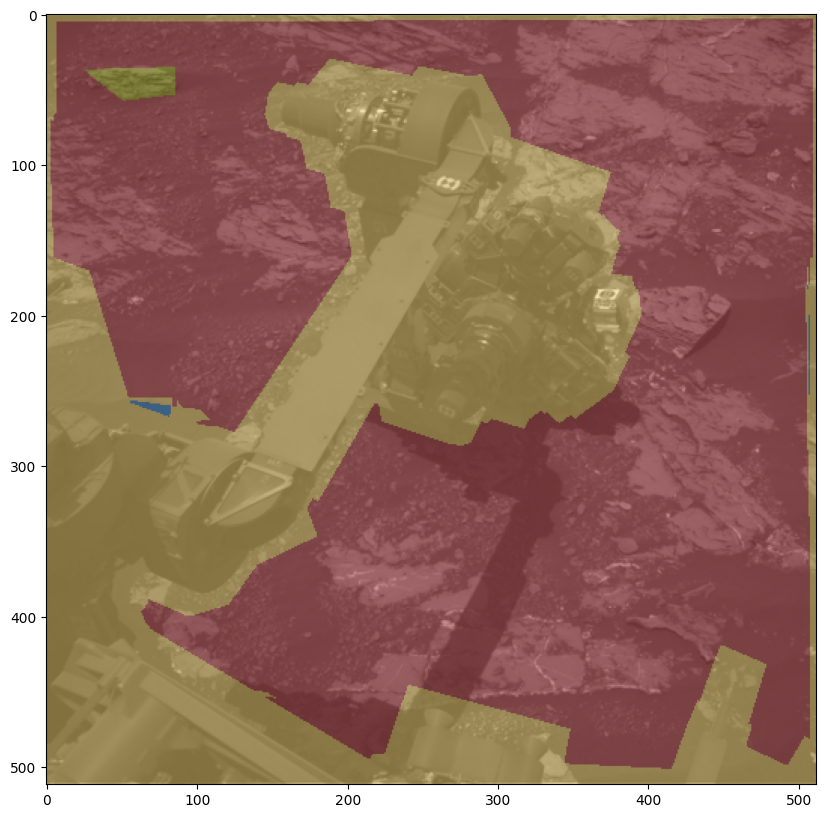

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# map every class to a random color
classes2names_colors = {k: list(np.random.choice(range(256), size=3)) for k,v in classes2names.items()}

def visualize_map(image, segmentation_map):
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in classes2names_colors.items():
        color_seg[segmentation_map == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

visualize_map(image, segmentation_map)

## Create PyTorch dataset

We create a regular PyTorch dataset, which prepares the examples for the model. We augment the training images by random resizing and cropping them to a fixed resolution (448x448), and normalize the color channels. This way, all our training images will have the same fixed resolution. Here we use the [Albumentations](https://albumentations.ai/) library for that purpose, but note that one can also use other libraries like Torchvision or Kornia.

 Note that the model will expect `pixel_values` of shape (batch_size, num_channels, height, width) as input. As Albumentations works on NumPy arrays (which uses a channels-last format), we make sure that the channels are first. The `labels` which the model also expects are of shape (batch_size, height, width) and indicate the ground truth label per pixel, for every example in the batch.

In [63]:
from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    original_image = np.array(item["image"])
    original_segmentation_map = np.array(item["label"])

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])

    # convert to C, H, W
    image = image.permute(2,0,1)

    return image, target, original_image, original_segmentation_map

Let's create the training and validation datasets (note that we only randomly crop for training images).

In [14]:
!pip install -q albumentations

In [64]:
import albumentations as A
ADE_MEAN= [0.61993144, 0.51421535, 0.36058366]
ADE_STD= [0.2162113,  0.34357504, 0.55873912]
#ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
#ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
#ADE_MEAN = ADE_MEAN.tolist()
#ADE_STD = ADE_STD.tolist()

train_transform = A.Compose([
    # hadded an issue with an image being too small to crop, PadIfNeeded didn't help...
    # if anyone knows why this is happening I'm happy to read why
    # A.PadIfNeeded(min_height=448, min_width=448),
    # A.RandomResizedCrop(height=448, width=448),
    A.Resize(width=448, height=448),
    #A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

val_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = SegmentationDataset(dataset_S5Mars["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset_S5Mars["validation"], transform=val_transform)

In [65]:
k = 3

pixel_values, target, original_image, original_segmentation_map = train_dataset[k]
print(pixel_values.shape)
print(target.shape)

torch.Size([3, 448, 448])
torch.Size([448, 448])


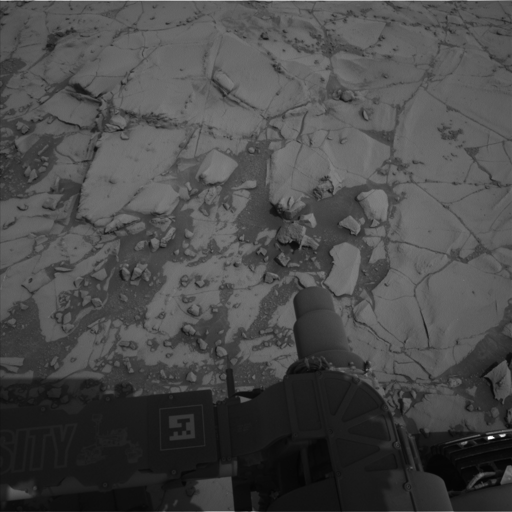

In [66]:
from PIL import Image

Image.fromarray(original_image)

In [67]:
[classes2names[id] for id in np.unique(original_segmentation_map).tolist()]

['bedrock', 'noLabel']

## Create PyTorch dataloaders

Next, we create PyTorch dataloaders, which allow us to get batches of data (as neural networks are trained on batches using stochastic gradient descent or SGD). We just stack the various images and labels along a new batch dimension.

In [68]:
from torch.utils.data import DataLoader

def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Let's check a batch:

In [69]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v),v[0].shape)

pixel_values torch.Size([8, 3, 448, 448])
labels torch.Size([8, 448, 448])
original_images 8 (512, 512, 3)
original_segmentation_maps 8 (512, 512)


Note that the pixel values are float32 tensors, whereas the labels are long tensors:

In [35]:
batch["pixel_values"].dtype

torch.float32

In [36]:
batch["labels"].dtype

torch.int64

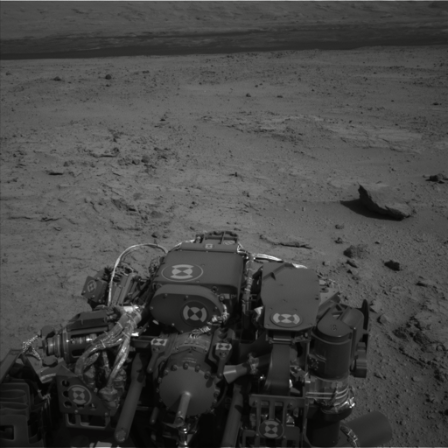

In [37]:
from PIL import Image

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = Image.fromarray(unnormalized_image)
unnormalized_image

In [38]:
[classes2names[id] for id in torch.unique(batch["labels"][0]).tolist()]

['soil', 'bedrock', 'bigRock', 'noLabel']

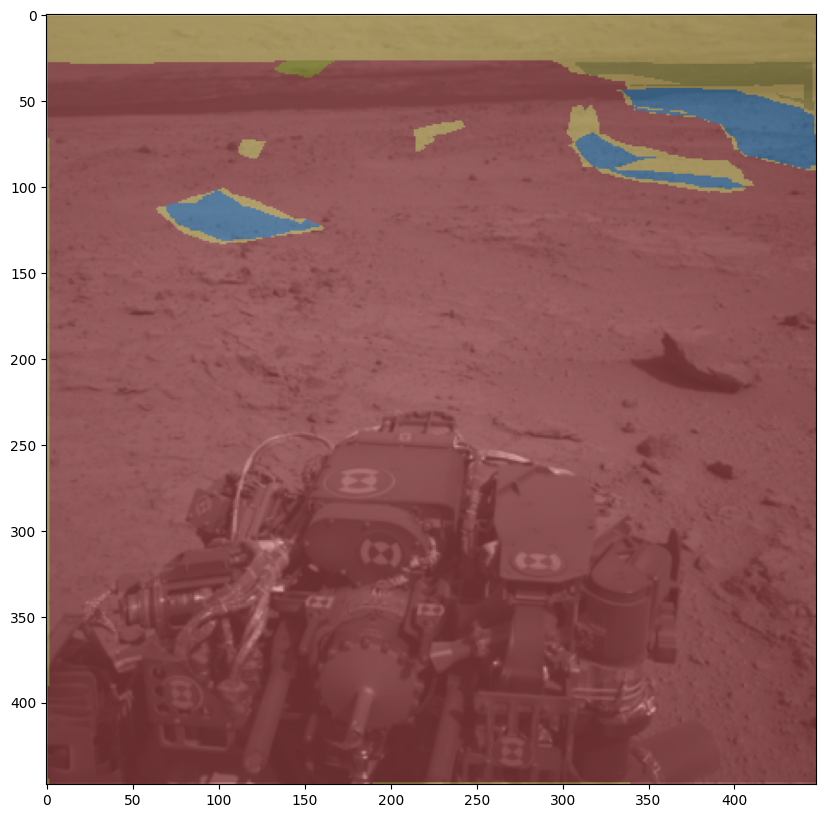

In [70]:
visualize_map(unnormalized_image, batch["labels"][0].numpy())

## Define model

Next, we define the model, which consists of DINOv2 as backbone + a linear classifier on top. DINOv2 is a regular vision transformer, hence it outputs "patch embeddings", meaning an embedding vector for each image patch. Since we use an image resolution of 448 pixels, and we use a DINOv2 model that has a patch resolution of 14 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L19), we get (448/14)**2 = 1024 patches out. So the model outputs a tensor of shape (batch_size, number of patches, hidden_size) = (batch_size, 1024, 768) for a batch of images (the model has a hidden size - also called embedding dimension - of 768 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L9)).

Next, we reshape this tensor to become (batch_size, 32, 32, 768), after which we apply the linear layer (below implemented as a Conv2D layer - which is equivalent to a linear transformation when you employ a kernel size of 1x1). This conv2D layer converts the patch embeddings into a logits tensor of shape (batch_size, num_labels, height, width) - which is what we need for semantic segmentation. This tensor contains scores as predicted by the model for all of the classes, for each pixel, for every example in the batch.

In [72]:
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      loss_fct = torch.nn.CrossEntropyLoss(ignore_index=255)
      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

We can instantiate the model as follows:

In [73]:
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=classes2names, num_labels=len(classes2names))

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
# Conta il numero di parametri addestrabili
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Stampa il numero di parametri addestrabili
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 86584325


Important: we don't want to train the DINOv2 backbone, only the linear classification head. Hence we don't want to track any gradients for the backbone parameters. This will greatly save us in terms of memory used:

In [75]:
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

Let's perform a forward pass on a random batch, to verify the shape of the logits, verify we can calculate a loss:

In [76]:
outputs = model(pixel_values=batch["pixel_values"], labels=batch["labels"])
print(outputs.logits.shape)
print(outputs.loss)

torch.Size([8, 5, 448, 448])
tensor(1.5054, grad_fn=<NllLoss2DBackward0>)


As can be seen, the logits are of shape (batch_size, num_labels, height, width). We can then just take the highest logit (score) for each pixel as the model's prediction.

## Train the model

We'll train the model in regular PyTorch fashion. We also use the mIoU (mean Intersection-over-Union) metric to evaluate the performance during training.

Note that I made this entire notebook just for demo purposes, I haven't done any hyperparameter tuning, so feel free to improve. You can also of course use other training frameworks (like the 🤗 Trainer, PyTorch Lightning, 🤗 Accelerate, ...).

In [31]:
import evaluate

metric = evaluate.load("mean_iou")

In [32]:
# Conta il numero di parametri addestrabili
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Stampa il numero di parametri addestrabili
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 7690


In [35]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 5e-5
epochs = 3

optimizer = AdamW(model.parameters(), lr=learning_rate)

# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# put model in training mode
model.train()
traning_losses = []
val_losses = []

for epoch in range(epochs):
  train_loss = 0.0
  
  val_loss = 0.0
  miou_val = 0.0
  mean_accuracy_val = 0.0
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()
      traning_losses.append(loss.item())
      train_loss += loss.item()
    
      
  with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss
      val_loss +=loss.item()
      
      predicted = outputs.logits.argmax(dim=1)
      metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
      metrics = metric.compute(num_labels=len(classes2names),
                          ignore_index=0,
                          reduce_labels=False,
      )
      miou_val += metrics["mean_iou"]
      mean_accuracy_val += metrics["mean_accuracy"]
  val_loss = val_loss / len(val_dataloader)
  miou_val = miou_val / len(val_dataloader)
  mean_accuracy_val = mean_accuracy_val / len(val_dataloader)
  
  print(f"{'Train Loss:':<20} {train_loss:.4f}")
  print(f"{'Val Loss:':<20} {val_loss:.4f}")
  print(f"{'Val Mean IoU:':<20} {miou_val:.4f}")
  print(f"{'Val Mean Accuracy:':<20} {mean_accuracy_val:.4f}")
  
  val_losses.append(val_loss)

Epoch: 0


  1%|          | 4/501 [00:15<31:29,  3.80s/it]


KeyboardInterrupt: 

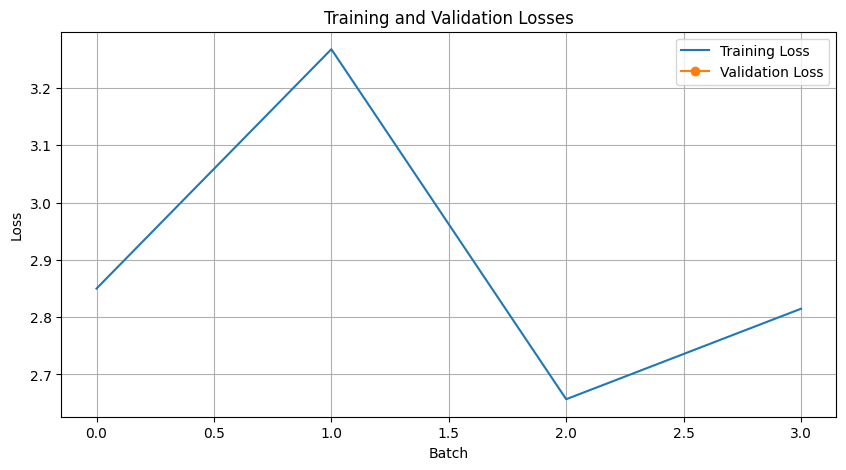

In [37]:
import matplotlib.pyplot as plt

# Assuming traning_losses and val_losses are lists containing the losses
# and len(train_dataloader) is the number of batches per epoch

# Calculate the number of batches per epoch
batches_per_epoch = len(train_dataloader)

# Create a list of epoch indices for validation losses
val_loss_epochs = [(i+1) * batches_per_epoch for i in range(len(val_losses))]

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(traning_losses, label='Training Loss')
plt.plot(val_loss_epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

## Inference

Once we've trained a model, we can perform inference on new images as follows:

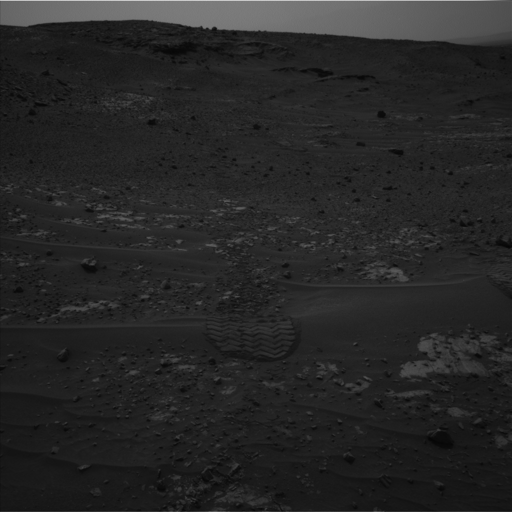

In [43]:
from PIL import Image

test_image = dataset_S5Mars["validation"][0]["image"]
test_image

In [44]:
pixel_values = val_transform(image=np.array(test_image))["image"]
print(pixel_values.shape)
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

(448, 448, 3)
torch.Size([1, 3, 448, 448])


In [45]:
# forward pass
with torch.no_grad():
  outputs = model(pixel_values.to(device))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [41]:
upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=test_image.size[::-1],
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)

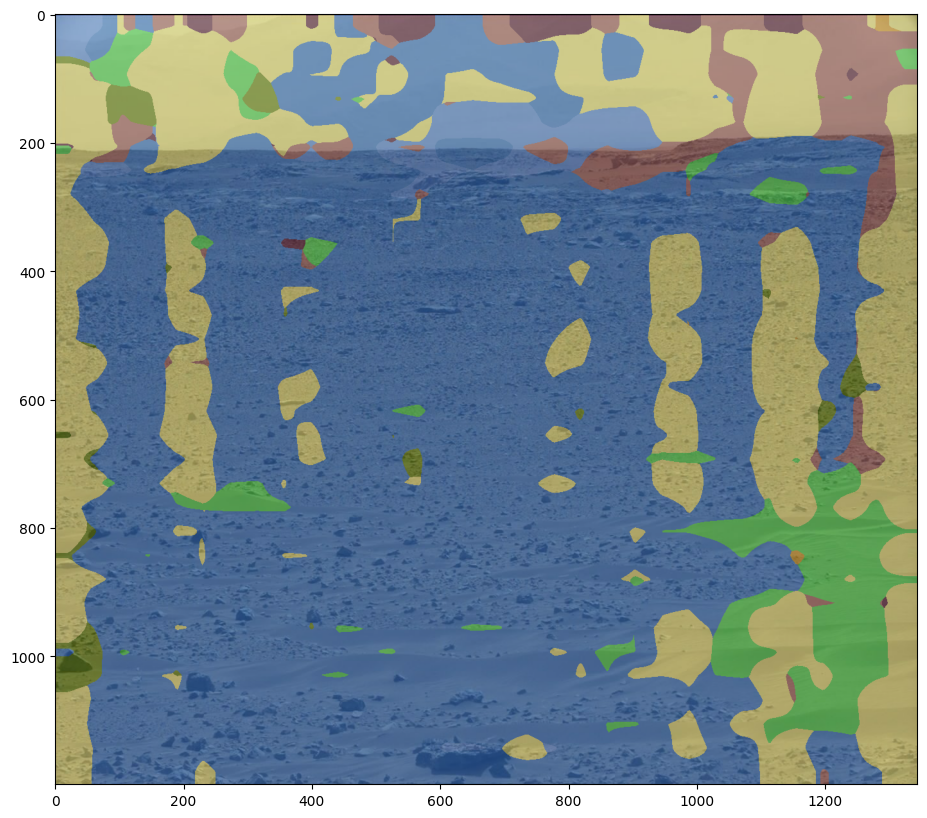

In [42]:
visualize_map(test_image, predicted_map.squeeze().cpu())

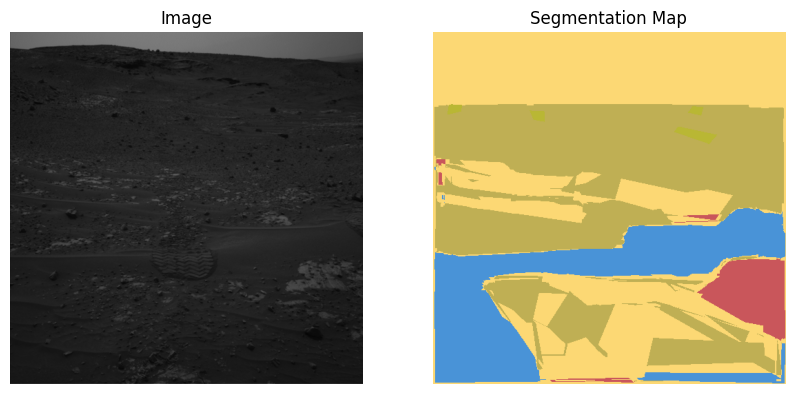

In [77]:
import numpy as np
from PIL import Image

def visualize_map(image, segmentation_map):
    # Convert segmentation_map to a NumPy array if it's a PngImageFile
    if isinstance(segmentation_map, Image.Image):
        segmentation_map = np.array(segmentation_map)
    
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in classes2names_colors.items():
        color_seg[segmentation_map == label, :] = color

    # Display the image and the segmentation map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(color_seg)
    plt.title('Segmentation Map')
    plt.axis('off')

    plt.show()
    
visualize_map(test_image, dataset_S5Mars["validation"][0]["label"])

This is just an illustrative example (I barely trained the model) but you can clearly see that training is working :) the model is able to segment the rice and sausages properly already on an unseen image.

In [84]:
modelsaved = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=classes2names, num_labels=len(classes2names))
saved = torch.load('C:/Users/alessio/Desktop/Tesi/Code/output/model.pth')
modelsaved.load_state_dict(saved)
device = "cuda" if torch.cuda.is_available() else "cpu"
modelsaved.to(device)
modelsaved.eval()

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dinov2ForSemanticSegmentation(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
      

In [85]:
S5Mars_test_images = "C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/images/test"
S5Mars_test_labels = "C:/Users/alessio/Desktop/Tesi/Code/dataset/ai4mars-dataset-merged-0.4-preprocessed-512/labels/test"

# Get the list of image files and label files
image_files_test = [os.path.join(S5Mars_test_images, f) for f in os.listdir(S5Mars_test_images) if f.endswith(('.png', '.jpg', '.jpeg'))]
label_files_test = [os.path.join(S5Mars_test_labels, f) for f in os.listdir(S5Mars_test_labels) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_to_label_test = {os.path.basename(img): lbl for img, lbl in zip(image_files_test, label_files_test)}




In [86]:
pixel_values = val_transform(image=np.array(test_image))["image"]
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

torch.Size([1, 3, 448, 448])


In [87]:
#Evaluate the model on the test set
test_data = []

for idx, img_path in enumerate(tqdm(image_files_test, desc="Processing images")):
    img_basename = os.path.basename(img_path)
    label_path = image_to_label_test[img_basename]
    test_data.append({
        'image': img_path,
        'label': label_path,
    })

Processing images: 100%|██████████| 322/322 [00:00<00:00, 322023.34it/s]


In [88]:
dataset_S5Mars_test = DatasetDict({
    'test': d.from_list(test_data, features=features),
})
print(dataset_S5Mars_test)
test_dataset = SegmentationDataset(dataset_S5Mars_test["test"], transform=train_transform)
#print the first element of the test dataset
k = 0
print(len(test_dataset[k]))
pixel_values, target, original_image, original_segmentation_map = test_dataset[k]


DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 322
    })
})
4


In [51]:
for idx, tuple in test_dataset:
    image = tuple[0].to(device)
    lbl = tuple[1].to(device)
    pixel_values = image.unsqueeze(0)
    
        # forward pass
    with torch.no_grad():
        #outputs = model(pixel_values.to(device))
        outputs = modelsaved(pixel_values.to(device))
    #upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
    #                                               size=image.size[::-1],
    #                                               mode="bilinear", align_corners=False)
    predicted_map = outputs.logits.argmax(dim=1).squeeze().cpu()
    img_cpu = image.squeeze().cpu()
    #permutation to H, W, C
    img_cpu = img_cpu.permute(1,2,0)
    visualize_map(img_cpu, predicted_map)
    break

ValueError: too many values to unpack (expected 2)

In [91]:
for idx, tuple in enumerate(test_dataset):
    image = tuple[0].to(device)
    lbl = tuple[1].to(device)
    pixel_values = image.unsqueeze(0)
    
        # forward pass
    with torch.no_grad():
        #outputs = model(pixel_values.to(device))
        outputs = modelsaved(pixel_values.to(device))
    #upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
    #                                               size=image.size[::-1],
    #                                               mode="bilinear", align_corners=False)
    predicted_map = outputs.logits.argmax(dim=1).squeeze().cpu()
    img_cpu = image.squeeze().cpu()
    #permutation to H, W, C
   # img_cpu = img_cpu.permute(1,2,0)
    
    predicted_map_img = Image.fromarray(predicted_map.byte().numpy())
    # change pixel values 4 to 255
    predicted_map_img = np.array(predicted_map_img)
    predicted_map_img[predicted_map_img == 4] = 255
    predicted_map_img = Image.fromarray(predicted_map_img)
    lbl_img = Image.fromarray(lbl.byte().cpu().numpy())
    
    if not os.path.exists("results"):
        os.makedirs("results")
    if not os.path.exists("results/predicted"):
        os.makedirs("results/predicted")
    if not os.path.exists("results/labels"):
        os.makedirs("results/labels")

    img_basename = str(idx).zfill(5)
    # Save images

    predicted_map_img.save(f"results/predicted/{img_basename}.png")
    lbl_img.save(f"results/labels/{img_basename}.png")
    break


In [53]:
import evaluate

metric = evaluate.load("mean_iou",)

In [ ]:
for tuple in  da:
    image = tuple["image"]
    lbl = tuple["label"]

    pixel_values = val_transform(image=np.array(image))["image"]
    pixel_values = torch.tensor(pixel_values)
    pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
        # forward pass
    with torch.no_grad():
        #outputs = model(pixel_values.to(device))
        outputs = modelsaved(pixel_values.to(device))
    #save in png the image, the label and the predicted map
    #image.save(f"{img_basename}_image.png")
    #lbl.save(f"{img_basename}_label.png")
    output = outputs.squeeze().cpu()
    
    
    